# Fitting a model to data with MCMC #

In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import plot_helper as plot_helper
import pandas as pd
import emcee # 2.2.1
import corner
import progressbar
import scipy.optimize as op
import os

In [2]:
# Make directories if required
plots_dir = './plots/'

if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

# What is MCMC?

This is a very short introduction to using MCMC for fitting a model to data; see references below for much more detailed examples. 

### The ground truth 

Let us suppose we are interested in some physical process which relates the quantities $x$ and $y$ as

\begin{equation}
y=y_{max}\frac{x}{x+K},
\end{equation}
with true parameter values $y_{max}=1$ and $K=2$.

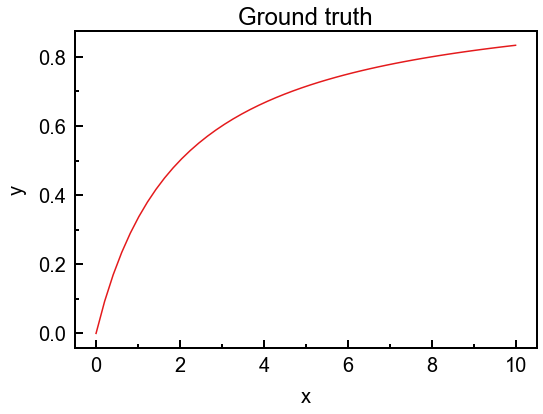

In [3]:
def model(x,ymax,K):
    return ymax*x/(x+K)
ymax=1
K=2
x=np.linspace(0,10,50)
y=model(x,ymax,K)
plot_helper.plot1(x,y,title='Ground truth')

Suppose we make some observations to measure $y_{max}$ and $K$. 

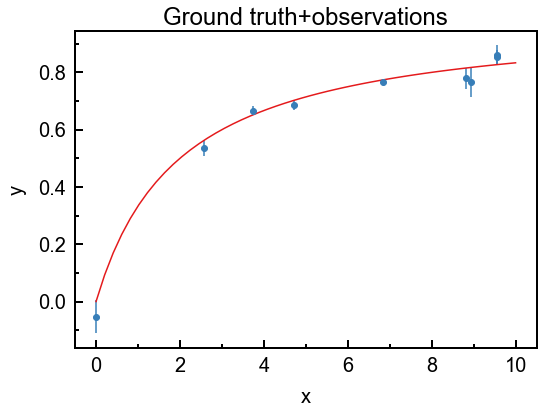

In [4]:
N=9
xobs=(np.random.rand(N))*10 
yerrtrue=0.03*np.random.randn(N) # normally distributed errors
yobs=model(xobs,ymax,K)+yerrtrue
yerr=yerrtrue*1 # Our estimated error is not necessarily equal to the true error
plot_helper.plot2(x,y,xobs,yobs,yerr,title='Ground truth+observations')

We would like to estimate the posterior probability distribution for $y_{max}$ and $K$, given these observations. In other words, we want $P(model|data)$, the probability of our model parameters given the data. Bayes' theorem gives an expression for this quantity:

\begin{equation}
P(model|data)=\frac{P(data|model)P(model)}{P(data)}
\end{equation}

Let's unpack this equation.

### The prior 

$P(model)$ is the prior; it is a description of the uncertainty we palce on the parameters in our model. For instance, let us assume that our parameters are initially normally distributed:

\begin{align}
y_{max}&=\mathcal{N}(1,0.2) \\
K&=\mathcal{N}(2,0.2)
\end{align}

so that our model becomes 

\begin{equation}
\hat{y}=\mathcal{N}(1,0.2)\frac{x}{x+\mathcal{N}(2,0.2)}.
\end{equation}

The prior probability of our model given parameters $y_{max}$ and $K$ is

\begin{equation}
P(model)=\mathcal{N}(y_{max}-1,0.2)\mathcal{N}(\mu-2,0.2).
\end{equation}

Typically we express these probablities in terms of log-probabilities so that the terms become additive:

\begin{equation}
\ln P(model)=\ln\mathcal{N}(y_{max}-1,0.2)+\ln\mathcal{N}(\mu-2,0.2).
\end{equation}

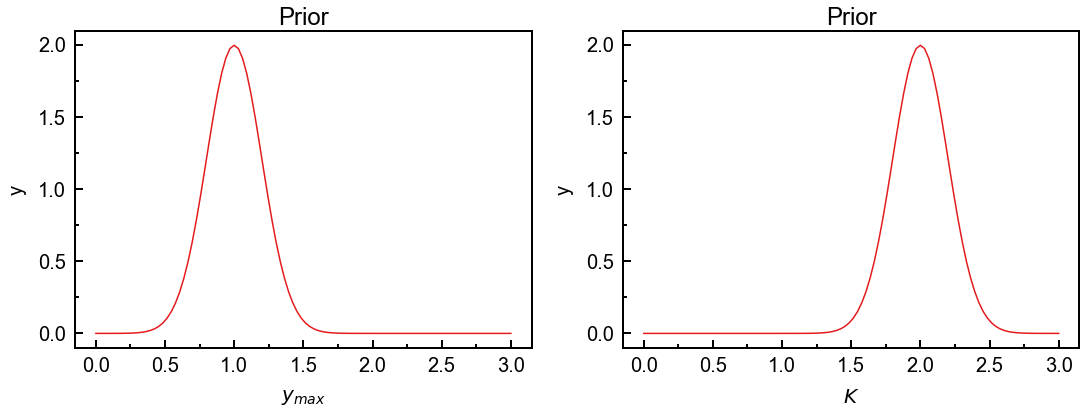

In [5]:
def prior(x,mu,sigma):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
mu1=1
mu2=2
sigma=0.2

xp=np.linspace(0,3,100)
y1=prior(xp,mu1,sigma)
y2=prior(xp,mu2,sigma)
plot_helper.plot3(xp,y1,xp,y2,title='Prior')

 ### The likelihood 

$P(data|model)$ is known as the likelihood. It's a measure of how likely it is that our model generates the observed data. In order to calculate this term we need a measure of how far our model predictions are from the actual observed data; typically we assume that deviations are due to normally-distributed noise, in which case our likelihood takes the simple form of squared residuals for each of the data points $y_n$ with error $s_n$:

\begin{equation}
P(data|model)=\prod_n\frac{1}{2\pi s_n^2}\exp\left(-\frac{(y_n-\hat{y}_n)^2}{2s_n^2}\right)
\end{equation}

The negative log-likelihood is therefore

\begin{equation}
\ln P(data|model)=-\frac{1}{2}\sum_n \left(\frac{(y_n-\hat{y}_n)^2}{s_n^2}+\ln (2 \pi s_n^2) \right)
\end{equation}

### MCMC 

What we want to do is determine the posterior probability distribution $\Pi(model|data)$. From this distribution we can determine probabilities as well as the expectation values of any quantity of interest by integrating. In other words, we would like to generate the probability landscape of likely model parameters, given our observations. In order to do this we must sample the landscape by varying the parameters. MCMC allows us to do this, without having to calculate the third term $P(data)$ in the Bayes formula which is nontrivial. The simplest MCMC algorithm is that of Metropolis: 

#### The Metropolis algorithm 

1) First we start at an initial point for the parameters $y_{max,0}$, $K_0$. We compute the probabilities 

\begin{equation}
P(data|y_{max,0},K_0)P(y_{max,0},K_0).
\end{equation}

2) Then we move to a new location $y_{max,1}$, $K_1$. This new location is called the proposal, and it's generated by randomly moving to a new point with probability given by a normal distribution centered around the current location, and a fixed variance (the proposal width).

3) We calculate the new probabilities 

\begin{equation}
P(data|y_{max,1},K_1)P(y_{max,1},K_1).
\end{equation}

4) We then calculate the acceptance ratio: 

\begin{equation}
\alpha=\frac{P(data|y_{max,1},K_1)P(y_{max,1},K_1)}{P(data|y_{max,0},K_0)P(y_{max,0},K_0)}.
\end{equation}

If $\alpha$ is greater than 1, i.e. the probability at the new point is higher, we accept the new point and move there. If $\alpha$ is smaller than 1, then we accept the move with a probability equal to $\alpha$. 


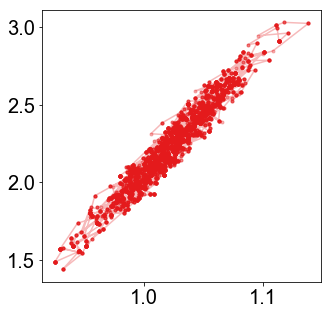

In [6]:
def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def like(pos,x,y,yerr):
    ymax=pos[0]
    K=pos[1]
    model=ymax*x/(x+K)
    inv_sigma2=1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2-np.log(inv_sigma2)))

def prior(pos):
    ymax=pos[0]
    K=pos[1]
    
    log_PRs=[normalprior(ymax,1,0.5), # Normal priors
            normalprior(K,2,0.5)]
    
    return np.sum(log_PRs)

def norm(pos,width):
    return pos+width*np.random.randn(2)


def metropolis(pos,MC,steps,width):
    for i in range(steps):
        proposal=norm(pos,width)
        newloglike=like(proposal,xobs,yobs,yerr)+prior(proposal)
        oldloglike=like(pos,xobs,yobs,yerr)+prior(pos)        
        if newloglike>=oldloglike: # If new probability is higher then accept
            pos=proposal
        else:
            a=np.exp(newloglike-oldloglike)
            if np.random.rand()<a: # If old probability is higher than only accept with probability a.
                pos=proposal
            else:
                pos=pos
                
        MC[i]=pos
    return MC

# Run MCMC here:

steps=10000 # Set number of steps
width=0.1 # Set proposal width
MC=np.zeros(steps*2).reshape(steps,2)
pos=np.array([1,2])
MC=metropolis(pos,MC,steps,width)

plt.figure(figsize=(5,5))
plt.plot(MC[:,0],MC[:,1],'.-',alpha=0.3);
plt.show()

Our Markov chain samples positions in parameter space, spending proportionately more time in regions of high probability mass. While the Metropolis algorithm is intuitive and instructive it is not the most efficient MCMC algorithm, so for the next part we will apply a more efficient ensemble sampler.

#### A more efficient algorithm: Goodman and Weare affine-invariant ensemble samplers 

In [7]:
def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y,yerr):
    ymax,K=theta
    model=ymax*x/(x+K)
    inv_sigma2=1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2-np.log(inv_sigma2)))

def lnprior(theta):
    ymax,K=theta
    
    if not (0<ymax and 0<K) : 
        return -np.inf # Hard-cutoff for positive value constraint

    log_PRs=[normalprior(ymax,1,0.5), # Normal priors
            normalprior(K,2,0.5)]
    
    return np.sum(log_PRs)

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [8]:
ndim,nwalkers,threads,iterations,tburn=2,20,8,1000,200
labels=["$y_{max}$","$K$"]
parametertruths=[1,2]
pos=[np.array([
    1*(1+0.05*np.random.randn()),
    1*(1+0.05*np.random.randn())]) for i in range(nwalkers)]
sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,args=(xobs,yobs,yerr),threads=threads)

 98% (988 of 1000) |##################### | Elapsed Time: 0:00:05 ETA:  0:00:00


Saving file...



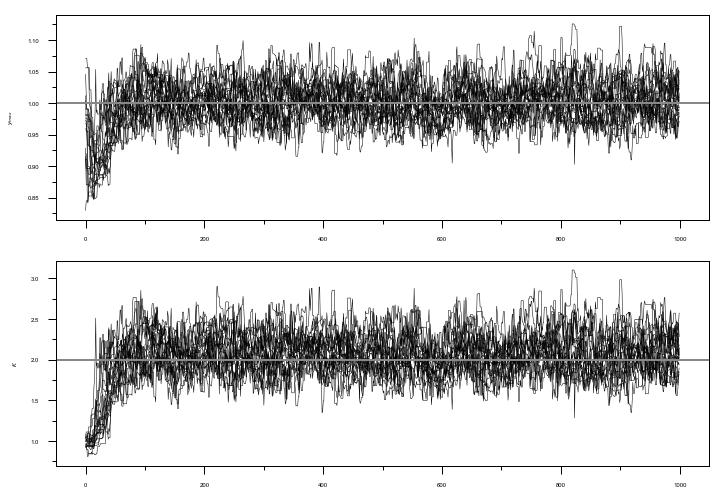

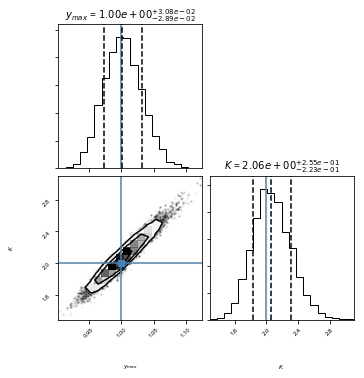

In [9]:
### Start MCMC
iterations=iterations
bar=progressbar.ProgressBar(max_value=iterations)
for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
    bar.update(i)
### Finish MCMC

samples=sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps, ndim)
samplesnoburn=sampler.chain[:,tburn:,:].reshape((-1,ndim)) # shape = (nsteps, ndim)

df=pd.DataFrame(samples)
#df.to_csv(path_or_buf='samplesout_simple.csv',sep=',') # Uncomment to save
            
plot_helper.plottraces(samples,labels,parametertruths,nwalkers,iterations,1)
fig=corner.corner(samplesnoburn, labels=labels,truths=parametertruths,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 10},verbose=False)
fig.savefig(plots_dir+"triangle_simple.pdf")


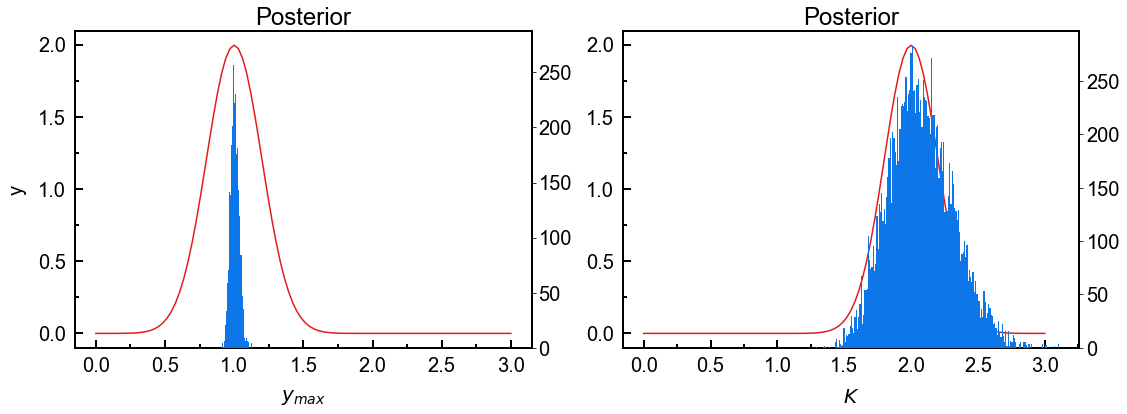

In [10]:
plot_helper.plot4(xp,y1,xp,y2,samplesnoburn,title='Posterior')

The plots above are instructive: what MCMC does is it generates samples of the posterior distribution, which is a product of the prior distribution and the likelihood function as determined by the observations. For strong priors and weak data, the posterior will be very similar to the prior. However, if the data are very strong or the prior very weak, the posterior will be more simliar to the likelihood. Playing around with the strength of the priors, by varying the $\sigma$ of the Gaussians, lets you see this effect.

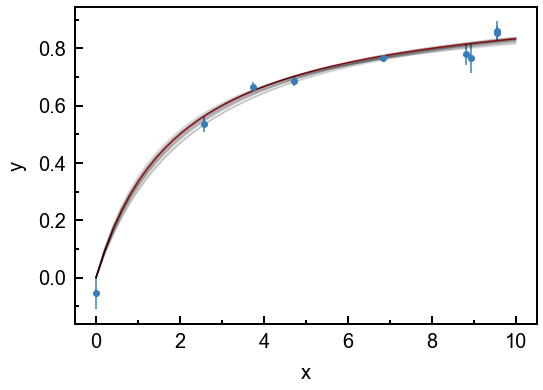

In [11]:
plot_helper.plot5(x,y,xobs,yobs,yerr,samplesnoburn,xlabel='x',ylabel='y',legend=False,title=False)

Finally, we can plot our model 'fits' by sampling randomly from the posterior distribution. This gives us a sense of the spread in our model predictions.

**References**

* MacKay 2003 http://www.inference.org.uk/itprnn/book.html - the bible for MCMC and inferential methods in general

* Goodman and Weare 2010 https://projecteuclid.org/euclid.camcos/1513731992 - original paper describing affine-invariant ensemble sampling

* emcee http://dfm.io/emcee/current/user/line/ - Python implementation of the Goodman and Weare algorithm

* Fitting a model to data https://arxiv.org/abs/1008.4686 - excellent tutorial on how to 'properly' fit your data

* Hamiltonian Monte Carlo https://arxiv.org/abs/1701.02434 - a more efficient MCMC algorithm, as implemented in Stan (http://mc-stan.org)

* Another nice online tutorial http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

# MCMC on dynamical systems 

In [19]:
import tellurium as te
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import plot_helper as plot_helper
import pandas as pd
import emcee
import corner
import progressbar

Here is a more sophisticated example similar to what you might encounter in the lab. Suppose we have a dynamical system (here modelled using tellurium) and you want to determine its kinetic parameters. For example, a Michaelis-Menten kinetic model for enzyme catalysis. Experimentally, you might do a titration of concentrations followed by inference to get the parameters. Here we do this in silico.

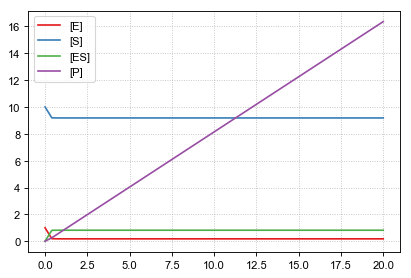

In [21]:
# Define model using tellurium, populate parameters, and run 
# a simulation to see its typical behaviour.

def MM_genmodel():
    ''' Michaelis-Menten enzyme model '''
       
    rr = te.loada('''
        J1: E+S->ES ; k1*E*S-k2*ES ;
        J2: ES->E+S+P ; k3*ES ;
        
        k1=0;
        k2=0;
        k3=0;

        ''')

    return(rr)

def simulatemodel(rr,tmax,nsteps,paramdict):
    
    for j in rr.model.getGlobalParameterIds():
        rr[j]=paramdict[j] # set parameters
        
    for j in rr.model.getFloatingSpeciesIds():
        rr[j]=paramdict[j] # set concentrations

    out=rr.simulate(0,tmax,points=nsteps)
    
    return(out,rr)

# Generate model
rr=MM_genmodel()

# Simulate model
tmax=20
nsteps=51
keys=['k1','k2','k3','E','S','ES','P']
params=[1,1,1,1,10,0,0]
paramdict=dict(zip(keys,params))
out,_=simulatemodel(rr,tmax,nsteps,paramdict)
rr.plot()

Let's do a titration experiment and MCMC to extract kinetic parameters for this enzyme.

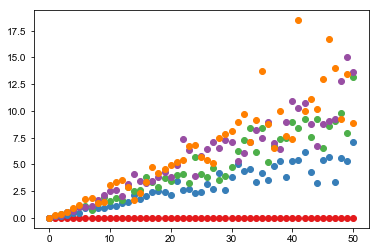

In [22]:
np.random.seed(42)

# Define experiment settings and generate synthetic data
def titration_expt(titration,k1,k2,k3,tmax,nsteps,rr):

    Parr=np.zeros((nsteps,len(titration)))
    for j in range(len(titration)):
        keys=['k1','k2','k3','E','S','ES','P']
        params=[k1,k2,k3,1,titration[j],0,0]
        paramdict=dict(zip(keys,params))
        out,_=simulatemodel(rr,tmax,nsteps,paramdict)
        Parr[:,j]=out[:,4]
    return Parr

rr=MM_genmodel()
tmax=20
nsteps=51
titrationvals=[0,5,10,15,20]

Parr=titration_expt(titrationvals,1,10,1,tmax,nsteps,rr)
Parr+=0.2*np.random.randn(Parr.shape[0],Parr.shape[1])*Parr+0.0001*np.random.randn(Parr.shape[0],Parr.shape[1]) # Add noise
plt.plot(Parr,'o') ; plt.show()

# Put data into yobs, yerr
yobs=Parr
yerr=Parr*0.2

# Regenerate model
rr=MM_genmodel()

# Define titration experiments and time steps
inputkeys=['tmax','nsteps','titration','model','y','yerr']
inputvalues=[tmax,nsteps,titrationvals,rr,yobs,yerr]
inputs=dict(zip(inputkeys,inputvalues))
np.random.seed(42)


In [23]:
# Define MCMC functions

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2
       
def lnlike(theta,inputs):
    k1,k2,k3=theta
    
    # DATA
    y=inputs['y']
    yerr=inputs['yerr']
    
    # MODEL INPUTS
    tmax=inputs['tmax']
    nsteps=inputs['nsteps']
    titration=inputs['titration']
    rr=inputs['model']
    
    ymodel=titration_expt(titration,k1,k2,k3,tmax,nsteps,rr)
   
    inv_sigma2=1.0/(yerr**2)
    return -0.5*(np.sum((y-ymodel)**2*inv_sigma2-np.log(inv_sigma2)))

def lnprior(theta):
    k1,k2,k3=theta
    
    if not (0<k1 and 0<k2 and 0<k3) : 
        return -np.inf # Hard-cutoff for positive value constraint

    log_PRs=[normalprior(k1,5,10),
            normalprior(k2,10,10),
            normalprior(k3,1,0.01)]
    
    return np.sum(log_PRs)

def lnprob(theta,inputs):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,inputs)

def gelman_rubin(chain):
    ''' Gelman-Rubin diagnostic for one walker across all parameters. This value should tend to 1. '''
    ssq=np.var(chain,axis=1,ddof=1)
    W=np.mean(ssq,axis=0)
    Tb=np.mean(chain,axis=1)
    Tbb=np.mean(Tb,axis=0)
    m=chain.shape[0]*1.0
    n=chain.shape[1]*1.0
    B=n/(m-1)*np.sum((Tbb-Tb)**2,axis=0)
    varT=(n-1)/n*W+1/n*B
    Rhat=np.sqrt(varT/W)
    return Rhat

The Gelman-Rubin diagnostic is a typical quantity used to tset convergence of MCMC chains. Technically this quantity cannot be used for emcee (ensemble sampling) as the walkers are not independent. But I've included it here as a reference. 

First do maximum likelihood estimation using a nonlinear optimizer. This gives us some starting values for MCMC.

3.75299115399 31.8489123426 0.813981591624


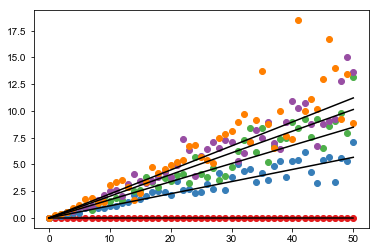

In [24]:
# Maximum likelihood

# Set initial positions
pos=[ 
5,  # k1
10, # k2    
1 # k3
]

nll= lambda *args: -lnlike(*args)
result=op.minimize(nll,pos,method='BFGS', args=(inputs))
paramstrue = result["x"]

k1_MLE=paramstrue[0]
k2_MLE=paramstrue[1]
k3_MLE=paramstrue[2]

print(k1_MLE,k2_MLE,k3_MLE)

tmax=20
nsteps=51
titration=[0,5,10,15,20]
ymodel=titration_expt(titration,k1_MLE,k2_MLE,k3_MLE,tmax,nsteps,rr)
plt.plot(yobs,'o')
plt.plot(ymodel,'k-',alpha=1) ; plt.show()


Now run MCMC using MLE values as initial positions.

 99% (2999 of 3000) |#################### | Elapsed Time: 0:08:49 ETA:  0:00:00


Saving file...

Mean acceptance fraction 0.624673333333
GR diagnostic for one walker 1.01109887789


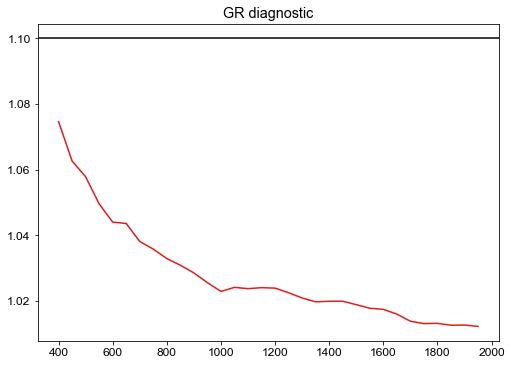

In [25]:
# Run MCMC

##### Set parameters here #####
ndim,nwalkers,threads,iterations,tburn=3,50,1,3000,1000
labels=["$k_1$","$k_2$","$k_3$"]
parametertruths=[1,10,1]
pos=[np.array([
    k1_MLE*(1+0.05*np.random.randn()),
    k2_MLE*(1+0.05*np.random.randn()),
    k3_MLE*(1+0.05*np.random.randn())]) for i in range(nwalkers)]
filename='MM'

##### The rest of the code is automatic #####
sampler=emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,args=([inputs]),threads=threads)

### Start MCMC
iterations=iterations
bar=progressbar.ProgressBar(max_value=iterations)
for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
    bar.update(i)
### Finish MCMC

samples=sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps, ndim)
samplesnoburn=sampler.chain[:,tburn:,:].reshape((-1,ndim)) # shape = (nsteps, ndim)

df=pd.DataFrame(samples)
#df.to_csv(path_or_buf=plots_dir+'samplesout_'+filename+'.csv',sep=',') # UNCOMMENT TO SAVE OUTPUT
            
plot_helper.plottraces(samples,labels,parametertruths,nwalkers,iterations,1)
fig=corner.corner(samplesnoburn, labels=labels,truths=parametertruths,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 10},verbose=False)
fig.savefig(plots_dir+'triangle_'+filename+'.pdf')

### Gelman-Rubin diagnostic 
# NOT RELIABLE ESTIMATE FOR EMCEE AS WALKERS NOT INDEPENDENT! 
plt.close("all")
figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. 
font_options={'size':'12','family':'sans-serif','sans-serif':'Arial'}
plt.rc('figure', **figure_options)
plt.rc('font', **font_options)
    
chain=sampler.chain[:,tburn:,:] # shape = nwalkers, iterations-tburn, ndim
print('Mean acceptance fraction', np.mean(sampler.acceptance_fraction))
print('GR diagnostic for one walker', gelman_rubin(chain)[0]) # Change index to get a different walker

chain_length=chain.shape[1]
step_sampling=np.arange(int(0.2*chain_length),chain_length,50)
rhat=np.array([gelman_rubin(chain[:,:steps,:])[0] for steps in step_sampling])
plt.plot(step_sampling,rhat); ax=plt.gca(); ax.axhline(y=1.1,color='k'); ax.set_title('GR diagnostic');
plt.show()


In [26]:
# Autocorrelation time analysis. 'c' should be as large as possible (default is 5)
tau = np.mean([emcee.autocorr.integrated_time(walker,c=1) for walker in sampler.chain[:,:,:]], axis=0)
print('Tau', tau)

Tau [ 40.46367221  40.06771078  30.35263478]


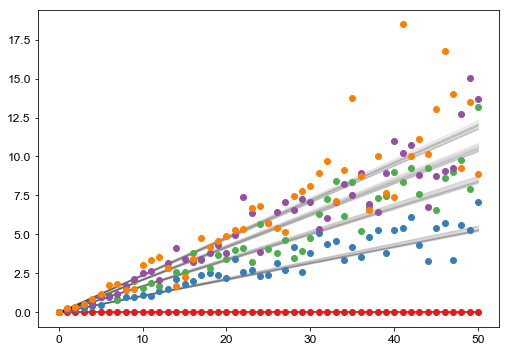

In [27]:
for k1,k2,k3 in samplesnoburn[np.random.randint(len(samplesnoburn), size=10)]:
    tmax=20
    nsteps=51
    titration=[0,5,10,15,20]
    ymodel=titration_expt(titration,k1,k2,k3,tmax,nsteps,rr)
    plt.plot(ymodel,'k-',alpha=0.1)
plt.plot(yobs,'o'); plt.show()